# Consistency check with $T_{\rm{X}}$ and $L_{\rm{X}}$ measured from Chandra data

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.io import fits
import os
from shutil import rmtree, copyfile
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm
from time import sleep
from subprocess import Popen, PIPE, TimeoutExpired
import fitsio
from fitsio import FITS
from IPython.display import display

# This is unfortunately necessary because the CIAO install through Conda overwrites the original HEADAS
#  environment variable, which breaks the XSPEC installation
os.environ['HEADAS'] = "/mnt/gs21/flash/turne540/software/heasoft-6.33.2/x86_64-pc-linux-gnu-libc2.31"

from regions import CircleSkyRegion, CirclePixelRegion, Regions, PixCoord, CircleAnnulusSkyRegion
from ciao_contrib.runtool import specextract

import xga
# This just sets the number of cores this analysis is allowed to use - IRRELEVANT HERE REALLY AS XGA DOESN'T SUPPORT CHANDRA YET
xga.NUM_CORES = 5
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/lum_temp_rad_pipeline')[0]+'xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.utils import xmm_sky
from xga.samples import ClusterSample
from xga.products import Image, ExpMap, RateMap, Spectrum
from xga.imagetools.misc import sky_deg_scale
from xga import BASE_XSPEC_SCRIPT, XGA_EXTRACT

%matplotlib inline

In [2]:
xga.__version__

'v0.5.0'

## Setting up directories

Need to make sure that some of the directories that we will be storing output files and figures in actually exist:

In [3]:
# This is where we store the region files output to make the Chandra spectral generation easier
if not os.path.exists('../../outputs/chandra_reg_files/'):
    os.makedirs('../../outputs/chandra_reg_files/')

# And here will live the fitting scripts, and their out-files
if not os.path.exists('../../outputs/chandra_fits/'):
    os.makedirs('../../outputs/chandra_fits/')

## Setting up useful functions

This is mainly for the XSPEC script setup function - which is functionally identical to the XGA `single_temp_apec()` function, but adapted to avoid using XGA sources and to use the Chandra spectra generated in this analysis. This is only necessary because Chandra support in XGA is early in development, and isn't yet ready for use:

In [4]:
def gen_xspec_script(source, spec_objs, script_out, start_temp=Quantity(3, 'keV'), freeze_met=True, freeze_temp=False, 
                     freeze_nh=True, spectrum_checking=True, lo_en=Quantity(0.4, 'keV'), hi_en=Quantity(7.0, 'keV'), 
                     lum_en: Quantity = Quantity([[0.5, 2.0], [0.01, 100.0]], "keV")):
    model = "constant*tbabs*apec"
    par_names = "{factor nH kT Abundanc Redshift norm}"
    lum_low_lims = "{" + " ".join(lum_en[:, 0].to("keV").value.astype(str)) + "}"
    lum_upp_lims = "{" + " ".join(lum_en[:, 1].to("keV").value.astype(str)) + "}"

    specs = "{" + " ".join([os.path.abspath(spec.path) for spec in spec_objs]) + "}"
    
    # Whatever start temperature is passed gets converted to keV, this will be put in the template
    t = start_temp.to("keV", equivalencies=u.temperature_energy()).value
    # Another TCL list, this time of the parameter start values for this model.
    par_values = "{{{0} {1} {2} {3} {4} {5}}}".format(1., source.nH.to("10^22 cm^-2").value, t, 0.3,
                                                      source.redshift, 1.)

    # Set up the TCL list that defines which parameters are frozen, dependent on user input - this can now
    #  include the temperature, if the user wants it fixed at the start value
    freezing = "{{F {n} {t} {a} T F}}".format(n="T" if freeze_nh else "F",
                                              t="T" if freeze_temp else "F",
                                              a="T" if freeze_met else "F")

    # Set up the TCL list that defines which parameters are linked across different spectra, only the
    #  multiplicative constant that accounts for variation in normalisation over different observations is not
    #  linked
    linking = "{F T T T T T}"

    # If the user wants the spectrum cleaning step to be run, then we have to set up some acceptable
    #  limits. For this function they will be hardcoded, for simplicities' sake, and we're only going to
    #  check the temperature, as it's the main thing we're fitting for with constant*tbabs*apec
    if spectrum_checking:
        check_list = "{kT}"
        check_lo_lims = "{0.01}"
        check_hi_lims = "{20}"
        check_err_lims = "{15}"
    else:
        check_list = "{}"
        check_lo_lims = "{}"
        check_hi_lims = "{}"
        check_err_lims = "{}"

    # This sets the list of parameter IDs which should be zeroed at the end to calculate unabsorbed
    #  luminosities. I am only specifying parameter 2 here (though there will likely be multiple models
    #  because there are likely multiple spectra) because I know that nH of tbabs is linked in this
    #  setup, so zeroing one will zero them all.
    nh_to_zero = "{2}"

    # Read in the template file for the XSPEC script.
    with open(BASE_XSPEC_SCRIPT, 'r') as x_script:
        script = x_script.read()

    dest_dir = os.path.dirname(script_out)
    out_file = os.path.join(dest_dir, os.path.basename(script_out)[:-4] + "_fit_results")

    # The template is filled out here, taking everything we have generated and everything the user
    #  passed in. The result is an XSPEC script that can be run as is.
    script = script.format(xsp=XGA_EXTRACT, ab='angr', md="leven", H0=source.cosmo.H0.value,
                           q0=0., lamb0=source.cosmo.Ode0, sp=specs, lo_cut=lo_en.to("keV").value,
                           hi_cut=hi_en.to("keV").value, m=model, pn=par_names, pv=par_values,
                           lk=linking, fr=freezing, el=1, lll=lum_low_lims, lul=lum_upp_lims,
                           of=out_file, redshift=source.redshift, lel=68, check=spectrum_checking, cps=check_list,
                           cpsl=check_lo_lims, cpsh=check_hi_lims, cpse=check_err_lims, ns=True,
                           nhmtz=nh_to_zero)

    # Write out the filled-in template to its destination
    with open(script_out, 'w') as xcm:
        xcm.write(script)

    return out_file

## Reading the XGA sample/results files from XMM analysis

We read in the files generated by our various runs of the XGA-LTR in another notebook in this repository. They contain the radii we measured, as well as other useful information - we're going to use Chandra to measure properties within the XMM defined radii (for the limited groups that have Chandra coverage):

In [5]:
r2500_samp = pd.read_csv('../../outputs/results/ltr_r2500_froztemp_pipeline_results.csv')

As previously stated, few of our groups have usable Chandra coverage, so we'll cut down the results files to leave only the relevant entries:

In [6]:
with_ch_names = ['12833A', '12833B', 'J215504.8-093520', 'J215437.2-091532.4']

r2500_samp = r2500_samp[r2500_samp['name'].isin(with_ch_names)]

As an illustration of the file content:

In [7]:
r2500_samp

,name,ra,dec,redshift,r2500,r2500+-,froz_Tx2500,froz_Tx2500+-,Lx2500_0.5-2.0,Lx2500_0.5-2.0-,Lx2500_0.5-2.0+,Lx2500_0.01-100.0,Lx2500_0.01-100.0-,Lx2500_0.01-100.0+,Lx2500ce_0.5-2.0,Lx2500ce_0.5-2.0-,Lx2500ce_0.5-2.0+,Lx2500ce_0.01-100.0,Lx2500ce_0.01-100.0-,Lx2500ce_0.01-100.0+
9,12833A,129.49680,44.248700,0.145,270.612558,9.269351,1.955483,0.094645,3.475465e+42,2.068244e+41,1.927716e+41,7.737077e+42,3.927438e+41,5.874377e+41,2.880157e+42,1.726556e+41,1.646949e+41,6.411802e+42,4.306175e+41,5.675991e+41
10,12833B,129.44500,44.379000,0.145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,J215504.8-093520,328.76992,-9.588805,0.077,320.290493,8.716310,2.486649,0.096825,7.313000e+42,2.830628e+41,2.425141e+41,1.844060e+43,7.600723e+41,8.825033e+41,5.646341e+42,2.489706e+41,2.038891e+41,1.423792e+43,5.791577e+41,6.618353e+41
14,J215437.2-091532.4,328.65500,-9.259000,0.078,201.913921,12.503821,1.091877,0.105812,3.757561e+41,7.660391e+40,6.811378e+40,6.791156e+41,1.014206e+41,1.223269e+41,1.419073e+41,5.925401e+40,7.227321e+40,2.564735e+41,1.417362e+41,1.144950e+41


Dropping any with NaN radii:

In [8]:
r2500_samp = r2500_samp[~np.isnan(r2500_samp['r2500'])]
r2500_samp

,name,ra,dec,redshift,r2500,r2500+-,froz_Tx2500,froz_Tx2500+-,Lx2500_0.5-2.0,Lx2500_0.5-2.0-,Lx2500_0.5-2.0+,Lx2500_0.01-100.0,Lx2500_0.01-100.0-,Lx2500_0.01-100.0+,Lx2500ce_0.5-2.0,Lx2500ce_0.5-2.0-,Lx2500ce_0.5-2.0+,Lx2500ce_0.01-100.0,Lx2500ce_0.01-100.0-,Lx2500ce_0.01-100.0+
9,12833A,129.49680,44.248700,0.145,270.612558,9.269351,1.955483,0.094645,3.475465e+42,2.068244e+41,1.927716e+41,7.737077e+42,3.927438e+41,5.874377e+41,2.880157e+42,1.726556e+41,1.646949e+41,6.411802e+42,4.306175e+41,5.675991e+41
13,J215504.8-093520,328.76992,-9.588805,0.077,320.290493,8.716310,2.486649,0.096825,7.313000e+42,2.830628e+41,2.425141e+41,1.844060e+43,7.600723e+41,8.825033e+41,5.646341e+42,2.489706e+41,2.038891e+41,1.423792e+43,5.791577e+41,6.618353e+41
14,J215437.2-091532.4,328.65500,-9.259000,0.078,201.913921,12.503821,1.091877,0.105812,3.757561e+41,7.660391e+40,6.811378e+40,6.791156e+41,1.014206e+41,1.223269e+41,1.419073e+41,5.925401e+40,7.227321e+40,2.564735e+41,1.417362e+41,1.144950e+41


## Setting up an XGA ClusterSample

Unlike our overall XMM analysis, we will not be using XGA to measure temperatures and luminosities from Chandra observations - this is because Chandra support is still early in development. We will still declare a ClusterSample however, simply because it will extract nH values for us, and may help set up some of the arguments for Chandra specextract and the eventual XSPEC fits:

In [9]:
srcs = ClusterSample(r2500_samp['ra'].values, r2500_samp['dec'].values, r2500_samp['redshift'].values, 
                     r2500_samp['name'].values, r2500=Quantity(r2500_samp['r2500'].values, 'kpc'), 
                     use_peak=False, load_fits=True, clean_obs=False)
srcs.info()
srcs.suppressed_warnings

Setting up Galaxy Clusters: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


-----------------------------------------------------
Number of Sources - 3
Redshift Information - True
Sources with ≥1 detection - 3 [100%]
-----------------------------------------------------




/mnt/home/turne540/software/anaconda3/envs/chandra_daxa_dev/lib/python3.11/site-packages/xga/samples/extended.py:279: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


{'J215504.8-093520': ["J215504.8-093520 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data"],
 'J215437.2-091532.4': ['A PSF sized extended source has been detected in 0204310101 and is very close to the user supplied coordinates of J215437.2-091532.4. It will not be excluded from analysis due to the possibility of a mis-identified cool core']}

## Defining which Chandra observations are relevant for each group

As we don't have an XGA ClusterSample to do this for us, we previously examined the Chandra obserations and identified which are relevant to each of the groups - here this information is placed in a dictionary so that it can be accessed programmatically: 

In [10]:
rel_ch_obs = {'12833A': ['15378'], 
              '12833B': ['15378'], 
              'J215504.8-093520': ['2957', '2958'], 
              'J215437.2-091532.4': ['2957', '2958']}

Temporary notes of what specextract is going to want:

specextract  infile outroot [bkgfile] [asp] [dtffile] [mskfile]
[rmffile] [badpixfile] [dafile] [bkgresp] [weight] [weight_rmf]
[resp_pos] [refcoord] [correctpsf] [combine] [readout_streakspec]
[grouptype] [binspec] [bkg_grouptype] [bkg_binspec] [energy] [channel]
[energy_wmap] [binarfcorr] [binwmap] [binarfwmap] [parallel] [nproc]
[tmpdir] [clobber] [verbose]


## Generating Chandra spectra

### Setting up useful values

In [11]:
root_pth = "../../data/archives/OVIGroups/processed_data/chandra/{oi}/"
evt_pth = os.path.join(root_pth, "events/obsid{oi}-instACIS-subexpE001-en-cleanevents.fits")
im_pth = os.path.join(root_pth, "images/obsid{oi}-instACIS-subexpE001-en0.5_7.0keV-image.fits")
ex_pth = os.path.join(root_pth, "images/obsid{oi}-instACIS-subexpE001-en0.5_7.0keV-expmap.fits")
asp_pth = os.path.join(root_pth, 'misc', 'obsid{oi}-instACIS-subexpE001-aspectsolution.fits')
bpix_pth = os.path.join(root_pth, 'misc', 'obsid{oi}-instACIS-subexpE001-badpix.fits')
# A bug in DAXA means that the mask files generated in the reprocessing were not stored, so 
#  currently pointing at the raw data mask files as an interim measure
msk_pth = "../../data/chandra_raw/{oi}/secondary/acisf{long_oi}_*_msk1.fits"

# This is the path to the manually-defined contaminant region files for each source-ObsID combination
cont_reg_pth = "../../outputs/chandra_reg_files/manual_contaminant_regions/{n}-chandra-obsid{oi}-contaminants.reg"
cont_reg_radec_pth = "../../outputs/chandra_reg_files/manual_contaminant_regions/{n}-chandra-contaminants_RADEC.reg"

r2500_inn_bck_fac = 2
r2500_out_bck_fac = 3

# Controls the binning applied to the spectra
min_counts = 25

### Loading in images

This step might seem unnecessary for the generation of spectra, but any extraction or contaminant regions that we define will have to be put into the Chandra 'sky' coordinate system (the tools will not accept RA-Dec regions) - an easy-ish way to do that conversion is to use an XGA image's coordinate conversion functionality:

In [12]:
rel_ch_rts = {src_name: {} for src_name in rel_ch_obs}
for src_name in rel_ch_obs:
    if src_name not in srcs.names:
        continue
        
    rel_src = srcs[src_name]
    rel_ois = rel_ch_obs[src_name]
    
    for oi in rel_ois:
        cur_im_pth = im_pth.format(oi=oi)        
        cur_im = Image(cur_im_pth, oi, 'ACIS', "", "", "", Quantity(0.5, 'keV'), Quantity(7.0, 'keV'))

        cur_ex_pth = ex_pth.format(oi=oi)
        cur_ex = ExpMap(cur_ex_pth, oi, 'ACIS', "", "", "", Quantity(0.5, 'keV'), Quantity(7.0, 'keV'))

        cur_rt = RateMap(cur_im, cur_ex)
        rel_ch_rts[src_name][oi] = cur_rt
        cur_rt.src_name = src_name
        cur_rt.image.src_name = src_name
        cur_rt.expmap.src_name = src_name
        
        # cur_rt.view(rel_src.ra_dec)

### Setting up regions

In [13]:
rel_ch_reg_files = {src_name: {} for src_name in rel_ch_obs}
rel_ch_radec_reg_files = {src_name: {} for src_name in rel_ch_obs}

for src_name in rel_ch_obs:
    if src_name not in srcs.names:
        continue
        
    rel_src = srcs[src_name]
    radec_coord = SkyCoord(*rel_src.ra_dec)
    cur_r2500_deg = rel_src.get_radius('r2500', 'deg')

    cur_r2500_bck_inn = cur_r2500_deg * r2500_inn_bck_fac
    cur_r2500_bck_out = cur_r2500_deg * r2500_out_bck_fac

    rel_ois = rel_ch_obs[src_name]
    for oi in rel_ois:
        cur_rt = rel_ch_rts[src_name][oi]
        # Ignore the 'xmm_sky' units - this version of XGA is optimised for XMM data, this is really Chandra Sky coords
        sky_coord = PixCoord(*cur_rt.coord_conv(rel_src.ra_dec, 'xmm_sky').value)
        sky_to_deg = sky_deg_scale(cur_rt, rel_src.ra_dec, )
        sky_rad = (cur_r2500_deg / sky_to_deg).to(xmm_sky)

        sky_bck_inn_rad = (cur_r2500_bck_inn / sky_to_deg).to(xmm_sky)
        sky_bck_out_rad = (cur_r2500_bck_out / sky_to_deg).to(xmm_sky)

        # We also load the manually defined contaminant regions file into memory - we're going to append them on
        #  to the output R2500 and R2500 background region files, subtracting them from the spectrum
        cur_cont_reg = cont_reg_pth.format(n=src_name, oi=oi)
        with open(cur_cont_reg, 'r') as contamino:
            cont_regs = contamino.readlines()[1:]
            # Adds the '-' onto the front of each source line to mark it as something to be removed
            cont_regs = list(map(lambda x: "-" + x, cont_regs))
        
        reg_file = src_name + "-chandra-obsid{}".format(oi) + '-r2500FT.reg'
        r2500_reg_out = os.path.join('../../outputs/chandra_reg_files/', reg_file)

        # Unfortunately the regions module saving functionality doesn't include the CIAO format - functionally seems
        #  identical to DS9 (from my small exploration at least) but the first line is different. As such I'll 
        #  write it out manually
        with open(r2500_reg_out, 'w') as reggo:
            reggo.write("# Region file format: CIAO version 1.0\n")
            reggo.write("circle({x},{y},{r})".format(x=sky_coord.x, y=sky_coord.y, r=sky_rad.value))
            reggo.writelines(cont_regs)

        # BACK REG
        back_reg_file = src_name + "-chandra-obsid{}".format(oi) + '-r2500FTback.reg'
        back_r2500_reg_out = os.path.join('../../outputs/chandra_reg_files/', back_reg_file)
        with open(back_r2500_reg_out, 'w') as breggo:
            breggo.write("# Region file format: CIAO version 1.0\n")
            breggo.write("ANNULUS({x},{y},{ri},{ro})".format(x=sky_coord.x, y=sky_coord.y, ri=sky_bck_inn_rad.value, 
                                                             ro=sky_bck_out_rad.value))
            breggo.writelines(cont_regs)

        # Store the paths to region files in a dictionary
        rel_ch_reg_files[src_name][oi] = [r2500_reg_out, back_r2500_reg_out]

        # WE ALSO MAKE A REGION FILE IN RA-DEC COORDINATES FOR EASIER XGA VISUALISATION - INCLUDES THE BCKGRND REGION 
        #  IN THE SAME FILE, AGAIN JUST FOR VISUALISATION
        radec_r2500_reg = CircleSkyRegion(radec_coord, cur_r2500_deg)
        radec_r2500_reg.visual['linestyle'] = 'dashed'
        radec_r2500_back_reg = CircleAnnulusSkyRegion(radec_coord, cur_r2500_bck_inn, cur_r2500_bck_out)
        radec_r2500_back_reg.visual['color'] = 'white'

        # Then load in the manually defined contaminant regions (a version that was saved in RA-DEC coordinates) - making
        #  sure that they are set to be red to distinguish them from the other regions
        radec_cont_regs = []
        for reg in Regions.read(cont_reg_radec_pth.format(n=src_name)).regions:
            reg.visual['color'] = 'red'
            reg.visual['edgecolor'] = 'red'
            reg.visual['facecolor'] = 'red'
            radec_cont_regs.append(reg)

        Regions([radec_r2500_reg, radec_r2500_back_reg]+radec_cont_regs).write(r2500_reg_out.replace(".reg", "RADEC-vis.reg"), 
                                                                               format='ds9', overwrite=True)
        # ALSO STORE THE RADEC REGION FILE PATHS IN ANOTHER DICTIONARY
        rel_ch_radec_reg_files[src_name][oi] = r2500_reg_out.replace(".reg", "RADEC-vis.reg")

### Viewing the regions

This acts as a validation of the defined regions, and the contaminants that are to be removed:

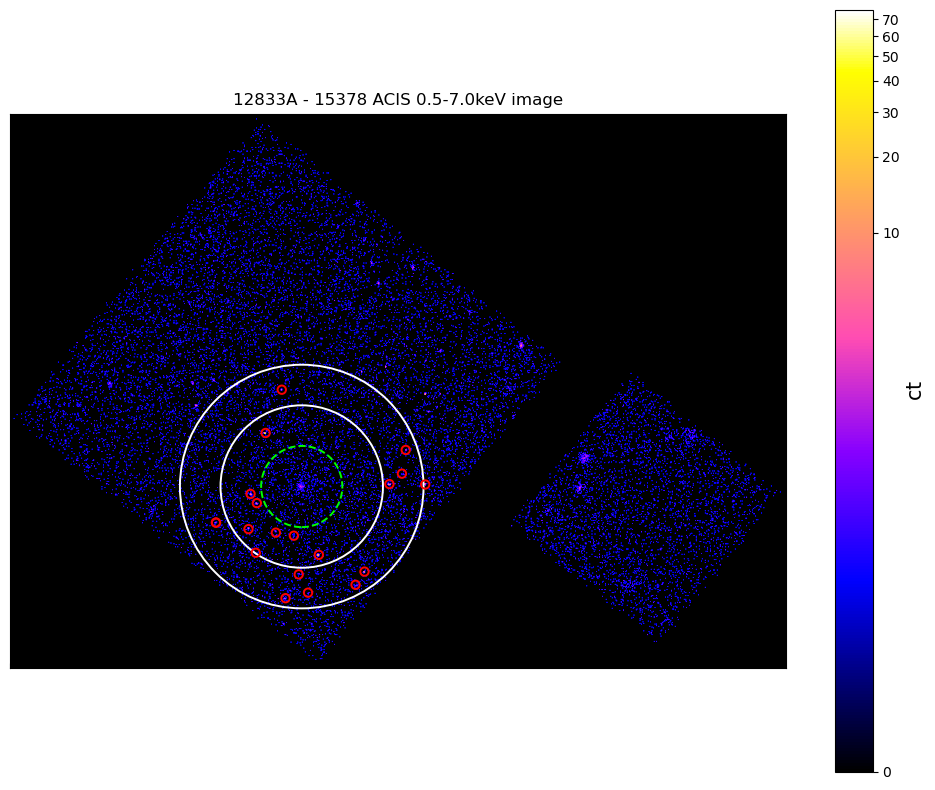

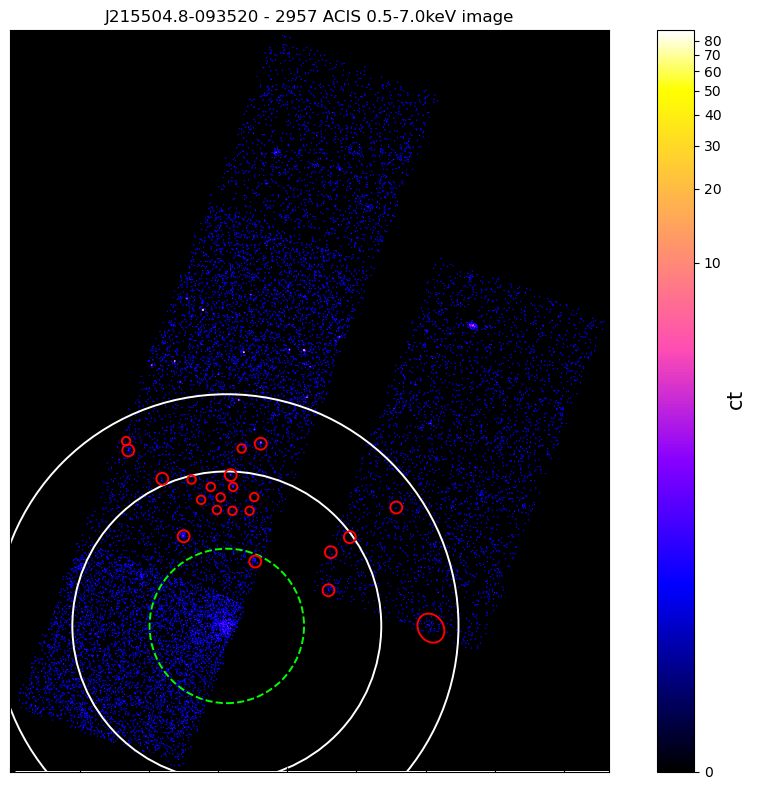

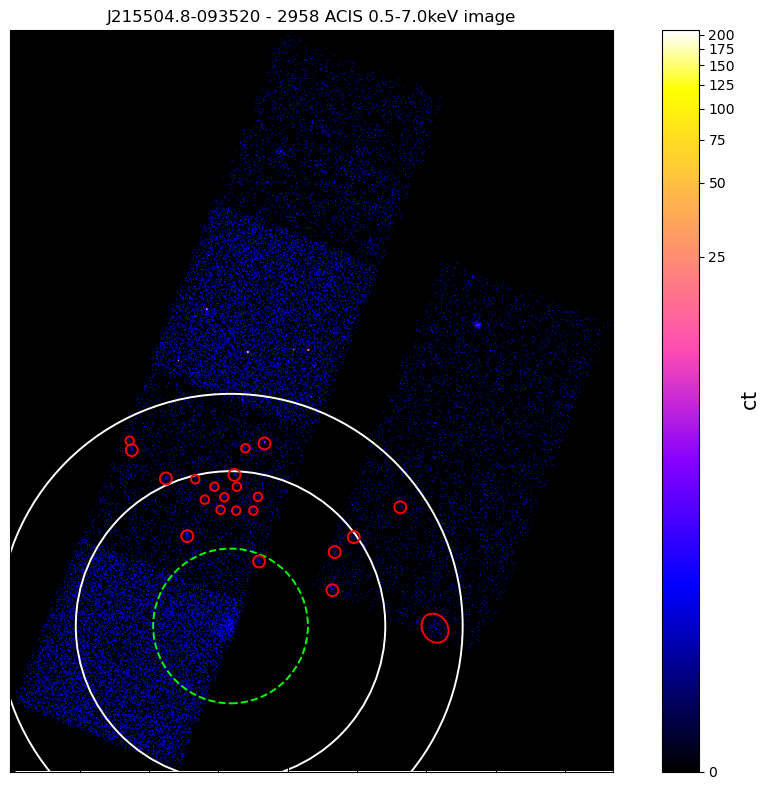

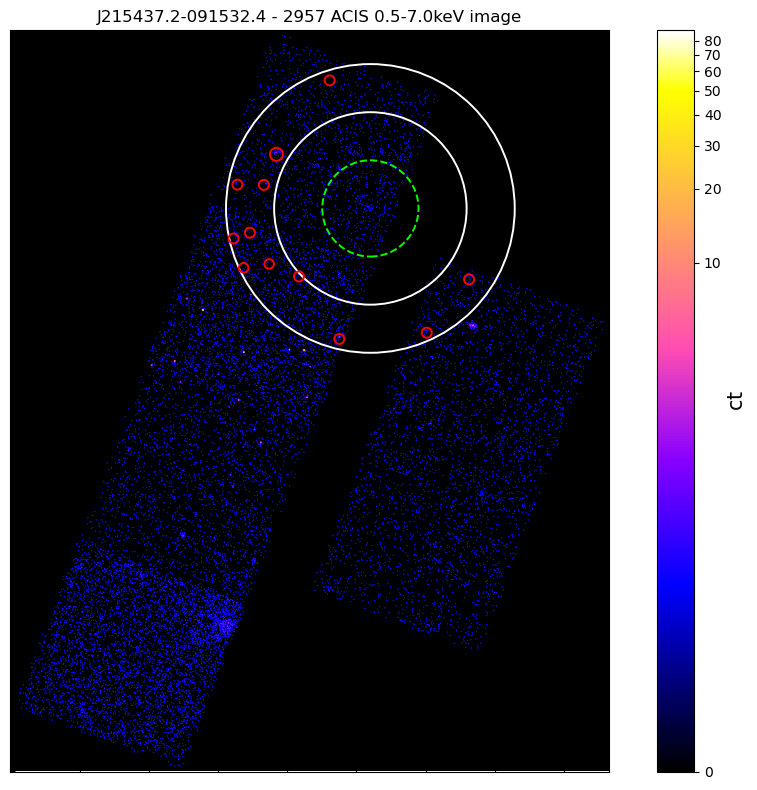

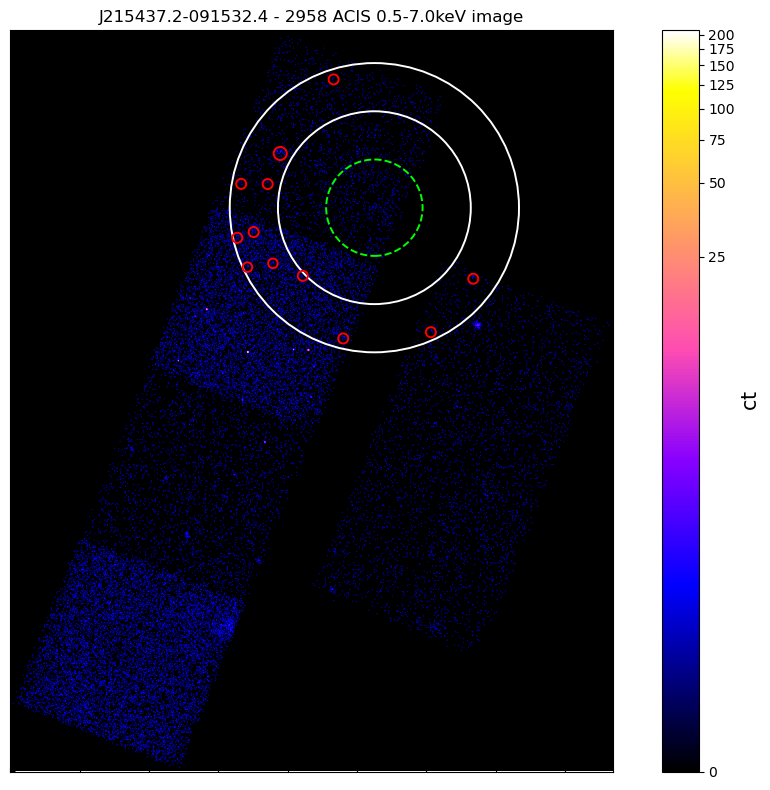

In [14]:
for src_name in rel_ch_reg_files:
    for oi in rel_ch_radec_reg_files[src_name]:
        # Grabbing the image we wish to view
        rel_im = rel_ch_rts[src_name][oi].image
        # Grabbing the VISUALISATION region file path
        rel_reg_file = rel_ch_radec_reg_files[src_name][oi]

        # This sidesteps a bug in XGA which will soon be fixed - adding RADec region files to the image
        #  requires a RA-DEC to pixel WCS is loaded, but it isn't being automatically loaded from the 
        #  file like it is meant to be - this call ensures that loading process has already happened
        rel_im.radec_wcs
        
        # Storing them in the image
        rel_im.regions = rel_reg_file
        # Viewing the image with the regions included
        rel_im.view(view_regions=True)
    print('\n\n')

### Generating spectra

Now that we've set up the region files that control what events we wish to include in our spectra, it is time to make them. Here we make use of the Python wrappings provided by Chandra's CIAO software - specifically the `specextract()` function, which is going to make all the spectra, RMFs, and ARFs, that we could possibly want.

In [15]:
rel_ch_specs = {src_name: {} for src_name in rel_ch_obs}

num_spec = len([oi for n in srcs.names for oi in rel_ch_obs[n]])
with tqdm(desc='Generating Chandra spectra', total=num_spec, miniters=1) as onwards:
    for src_name in srcs.names:
            
        rel_src = srcs[src_name]
        cur_r2500_deg = rel_src.get_radius('r2500', 'deg')
        
        rel_ois = rel_ch_obs[src_name]
        rel_regs = rel_ch_reg_files[src_name]
    
        for oi in rel_ois:
            r2500_reg_out, back_r2500_reg_out = rel_regs[oi]
            
            # Path to the relevant events list - this will be be passed to spectral generation along with a 
            #  filtering command that uses the defined region files
            rel_evt_pth = evt_pth.format(oi=oi)
            # Setting up those event + filtering strings
            filt_rel_evt = rel_evt_pth + "[sky=region({})]".format(r2500_reg_out)
            filt_rel_back_evt = rel_evt_pth + "[sky=region({})]".format(back_r2500_reg_out)
    
            # Fill in the paths for the housekeeping files we require
            rel_asp_pth = asp_pth.format(oi=oi)
            rel_bpix_pth = bpix_pth.format(oi=oi)
            rel_msk_pth = msk_pth.format(oi=oi, long_oi=oi.zfill(5))
            
            # And define where we want the finished spectra to end up
            out_prefix = "chandra_spec/r2500_froztemp/{n}_obsid{oi}".format(n=rel_src.name, oi=oi)
            
            # In case we're re-running things, if the final spectra already exist we won't re-run specextract
            if not os.path.exists(out_prefix+"_grp.pi"):
                specextract(infile=filt_rel_evt, outroot=out_prefix, bkgfile=filt_rel_back_evt, bkgresp='no', asp=rel_asp_pth, 
                            badpixfile=rel_bpix_pth, mskfile=rel_msk_pth, binspec=min_counts, weight='yes', weight_rmf='no', 
                            verbose=5, clobber=True, nproc=5)
    
            cur_sp_pth = out_prefix + '_grp.pi'
            cur_rmf_pth = os.path.abspath(out_prefix + '.rmf')
            cur_arf_pth = os.path.abspath(out_prefix + '.arf')
            cur_bck_sp_pth = os.path.abspath(out_prefix + '_bkg.pi')

            # This sets up an XGA spectrum instance with all the files we just generated - this is largely just to make things
            #  a little easier when setting up the XSPEC scripts to fit these data§
            cur_sp = Spectrum(cur_sp_pth, cur_rmf_pth, cur_arf_pth, cur_bck_sp_pth, rel_src.ra_dec, Quantity(0, 'deg'), 
                              cur_r2500_deg, oi, 'ACIS', True, min_counts, None, None, None, '', '', '')
            cur_sp.src_name = rel_src.name

            # Store the spectrum instance in a dictionary for later (this will make setting up the XSPEC scripts a little easier)
            rel_ch_specs[src_name][oi] = cur_sp
            # This is really daft, and the first time I've used this function since I started using Python, but the progress 
            #  bar doesn't seem to update in cases where the spectra already exist unless I slow down the loop somewhat 
            sleep(3)
            onwards.update(1)

Generating Chandra spectra: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


Generally users shouldn't be touching the internal methods like this, but currently an automatic updating of the RESPFILE, BACKFILE, etc. headers is only triggered when the spectrum has been generated by XGA, and as we have moved some files around we do want there to be an automatic update here.

In [16]:
for rn in rel_ch_specs:
    for oi, sp in rel_ch_specs[rn].items():
        sp._update_spec_headers("main")

## Fitting spectra

While we can't fit Chandra spectra directly through the XGA XSPEC interface yet, we can use the XGA XSPEC template script to make our life a little easier (and ensure that the fit process is identical to what we did for the XMM data):

In [17]:
ch_results = {}

for src_name in srcs.names:
    rel_src = srcs[src_name]
    rel_sps = list(rel_ch_specs[src_name].values())
    cur_out_dir = "../../outputs/chandra_fits/{n}/"
    
    if not os.path.exists(cur_out_dir.format(n=src_name)):
        os.makedirs(cur_out_dir.format(n=src_name))
    cur_script = os.path.join(cur_out_dir, "{n}_r2500FT_constant*tbabs*apec.xcm").format(n=src_name)

    cur_out_file = gen_xspec_script(rel_src, rel_sps, cur_script, lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.5, 'keV'))

    if not os.path.exists(cur_out_file + '.fits'):
        # So, installing CIAO through Conda (and possibly through other methods - haven't tested it) has the annoying behaviour
        #  of overwriting the existing $HEADAS environment variable, which then breaks the XSPEC install. That is fine if you can 
        #  manually reset that variable after the CIAO environment has been activated, but presents an issue for notebooks running 
        #  through an OnDemand-like system which we use - as the sub-processes spawned below inherit environment variables from 
        #  their parent, it may mean that the XSPEC fits are going to require some persuading to work
        cmd = "xspec - {}".format(cur_script)
        xspec_proc = Popen(cmd, shell=True, stdout=PIPE, stderr=PIPE)
        out, err = xspec_proc.communicate()
        out = out.decode("UTF-8").split("\n")
        err = err.decode("UTF-8").split("\n")
    
    if os.path.exists(cur_out_file + "_info.csv"):
        results = pd.read_csv(cur_out_file + "_results.csv", header="infer")
        # This is the csv with the fit results in, creates new fits file and adds in
        fitsio.write(cur_out_file + ".fits", results.to_records(index=False), extname="results", clobber=True)
        del results

        # The information about individual spectra, exposure times, luminosities etc.
        spec_info = pd.read_csv(cur_out_file + "_info.csv", header="infer")
        # Gets added into the existing file
        fitsio.write(cur_out_file + ".fits", spec_info.to_records(index=False), extname="spec_info", )
        del spec_info

        # This finds all the matching spectrum plot csvs were generated
        rel_path = "/".join(cur_out_file.split('/')[0:-1])
        # This is mostly just used to find how many files there are
        spec_tabs = [rel_path + "/" + sp for sp in os.listdir(rel_path)
                     if "{}_spec".format(cur_out_file) in rel_path + "/" + sp]
        for spec_i in range(1, len(spec_tabs)+1):
            # Loop through and redefine names like this to ensure they're in the right order
            spec_plot = pd.read_csv(cur_out_file + "_spec{}.csv".format(spec_i), header="infer")
            # Adds all the plot tables into the existing fits file in the right order
            fitsio.write(cur_out_file + ".fits", spec_plot.to_records(index=False), extname="plot{}".format(spec_i))
            del spec_plot

        # This reads in the fits we just made
        with FITS(cur_out_file + ".fits") as res_tables:
            tab_names = [tab.get_extname() for tab in res_tables]
            if "results" not in tab_names or "spec_info" not in tab_names:
                usable = False
        
        ch_results[src_name] = FITS(cur_out_file+'.fits')

## Exploring the results

In [18]:
for src_name in ch_results:
    cur_res = ch_results[src_name]
    print(src_name)
    print(Quantity(cur_res['results'][0][['kT|3', 'kT|3-', 'kT|3+']].tolist(), 'keV'))
    print(Quantity(cur_res['spec_info'][0][['Lx_0.5_2.0', 'Lx_0.5_2.0-', 'Lx_0.5_2.0+']].tolist(), 'erg/s')*1e+44)
    print(Quantity(cur_res['spec_info'][0][['Lx_0.01_100.0', 'Lx_0.01_100.0-', 'Lx_0.01_100.0+']].tolist(), 'erg/s')*1e+44)
    print('')

12833A
[1.2573016  0.20010629 0.32739697] keV
[5.00003836e+42 4.83688319e+41 4.84692406e+41] erg / s
[6.86266465e+42 6.99246234e+41 6.49766783e+41] erg / s

J215504.8-093520
[2.90505902 0.43451771 0.6618859 ] keV
[8.50409662e+42 2.16409288e+41 2.84157674e+41] erg / s
[1.82693584e+43 1.20736111e+42 1.22687517e+42] erg / s

